### 1) Imports

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

from scipy.constants import m_p, c, e

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
plt.close('all')

### 2) Variables we change

In [4]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(600)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_y = 20.18             #How many times the particles oscillate in phase space each turn 
Q_x = 20.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = 'file'      #Where the data for the run is saved

wakefieldOn = 1         # Turns on the wakefields

### 3) Variables we don't change

In [5]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 27.7 #28550064942279 # for 26 Gev
p0 = m_p*c*np.sqrt(gamma**2 - 1)

beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5038378975451
frev = c/circumference
print(frev)


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 55.1* np.ones(n_segments) #54.644808743169399 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 55.1* np.ones(n_segments) #54.509415262636274 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)

Qp_x, Qp_y = 0.0, 0.0 #10

# 2nd and 3rd order chroma
#Qp_x = np.array([7.4, 2.7e2, -1.8e6])
#Qp_y = np.array([1.7, 7.6e2, 1.4e6])


# detuning coefficients in (1/m)
app_x = 0.0  #2.4705e-15 #4e-11
app_xy = 0.0 #-0*2.25e-11
app_y = 0.0  #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
gamma_t = 18
alpha = 1/gamma_t**2
print(f'alpha {alpha}')
#alpha = 1.9e-3 # defined from the optics

Q_s = 0.014 # fro 4MV of the 200 MHz system . 0.017046597789257857 # for Q20 0.0051 for MD
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE BEAM
# ===========
macroparticlenumber = int(5e5) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2 # eta = 0.62e-3 for 26 Gev
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
sigma_z   = 0.27 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
print(sigma_dp)
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp
print(epsn_z)
#epsn_z = 0.35

# generate bunches for the different intensities
intensity_list = np.linspace(0.5e11, 3e11, 6)
#intensity_list = np.linspace(2.5e11, 4e11, 5)

for intensity in intensity_list:
#for intensity in intensity_list:
    print(f'Createing bunch for intensity:{intensity}')

    bunch = generate_Gaussian6DTwiss(
        macroparticlenumber, intensity, charge, mass, circumference, gamma,
        alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)
    xoffset = 0.25*sigma_x 
    yoffset = 0.25*sigma_y 
    
    bunch.x += xoffset
    bunch.y += yoffset
    
    afile = open(f'bunch_intensity{intensity/1e10}1e10', 'wb')
    pickle.dump(bunch, afile)
    afile.close()

43375.8650839722
alpha 0.0030864197530864196
0.0019271509289014582
0.5664923246828444
Createing bunch for intensity:50000000000.0
Createing bunch for intensity:100000000000.0
Createing bunch for intensity:150000000000.0
Createing bunch for intensity:200000000000.0
Createing bunch for intensity:250000000000.0
Createing bunch for intensity:300000000000.0


In [6]:
np.std(bunch.z)

0.27059920998011944

### Wakefields

In [7]:
# SLICER FOR WAKEFIELDS
# ============
n_slices = 500 # 500
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)

# WAKEFIELD
# ==========
n_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn

#wakefile1=('./wakes_files/SPS_complete_wake_model_2018_Q20.txt')
wakefile1=('./wakes_files/SPS_complete_wake_model_2018_Q20.txt')
waketable_columns = ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y']
ww1 = WakeTable(wakefile1, waketable_columns, n_turns_wake=n_turns_wake)

# only dipolar kick
#my_length = len(ww1.wake_table['quadrupole_x'])
#ww1.wake_table['quadrupole_x'] = np.zeros(my_length)
#ww1.wake_table['quadrupole_y'] = np.zeros(my_length)



wake_field = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)

dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


### 4) Create transverse and longitudinal map

In [8]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [9]:
t0 = time.clock()

one_turn_map = [transverse_map[0], wake_field, longitudinal_map]

#for i, segment in enumerate(transverse_map):
#    one_turn_map.append(segment)
#    if wakefieldOn:
#       if i+1 == i_wake:
#            one_turn_map.append(wake_field)
            #one_turn_map.append(wake_field_wall)
#one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


### 6) Start tracking

In [10]:
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
#meanXsq = np.zeros(n_damped_turns)
#meanYsq = np.zeros(n_damped_turns)
#emitX = np.zeros(n_damped_turns)
#emitY = np.zeros(n_damped_turns)
    
# Iterate over the intensities, reload bunch object from file for each intensisty
#intensity_list = np.linspace(0, 5e10, 5)
for intensity in intensity_list:
#for intensity in intensity_list:    
    print(f'Tracking for intensity:{intensity}')
    
    file2 = open(f'bunch_intensity{intensity/1e10}1e10', 'rb')
    bunch = pickle.load(file2)
    file2.close()
    for i in range(n_turns):
        #These next two lines actually "run" the simulation - the computationally heavy part
        for m in one_turn_map:
            m.track(bunch)
            
      
        if i%decTurns is  0:
            j = int(i/decTurns)
            meanX[j] = np.mean(bunch.x)
            meanY[j] = np.mean(bunch.y)
            #meanXsq[j] = np.mean((bunch.x-np.mean(bunch.x))**2)
            #meanYsq[j] = np.mean((bunch.y-np.mean(bunch.y))**2)
            #emitX[j] = bunch.epsn_x()
            #emitY[j] = bunch.epsn_y()


    dataExport = [meanX, meanY]#, meanXsq, meanYsq, emitX, emitY]

    f = open(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', 'w')

    with f:
        out = csv.writer(f, delimiter=',')
        out.writerows(zip(*dataExport))

    print('--> Done.')

    print("Simulation time in seconds: " + str(time.clock() - t0))



Tracking for intensity:50000000000.0
--> Done.
Simulation time in seconds: 68.983964
Tracking for intensity:100000000000.0


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


--> Done.
Simulation time in seconds: 143.37232300000002
Tracking for intensity:150000000000.0
--> Done.
Simulation time in seconds: 214.28557500000002
Tracking for intensity:200000000000.0
--> Done.
Simulation time in seconds: 285.189361
Tracking for intensity:250000000000.0
--> Done.
Simulation time in seconds: 355.889005
Tracking for intensity:300000000000.0
--> Done.
Simulation time in seconds: 424.916726


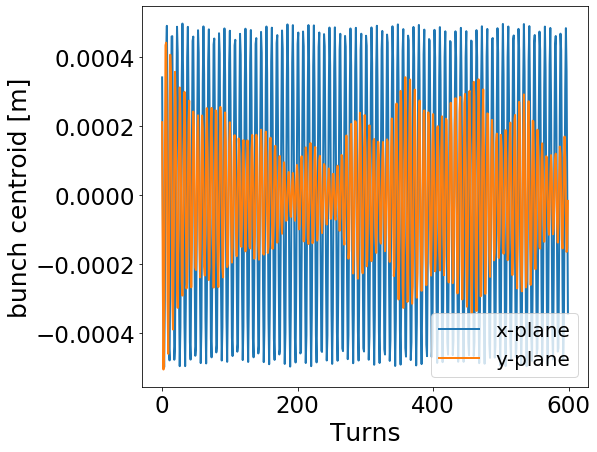

In [14]:
plt.plot(meanX, label='x-plane')
plt.plot(meanY, label='y-plane')
plt.xlabel('Turns')
plt.ylabel('bunch centroid [m]')
plt.legend()

### 7) Compute tunes

In [15]:
Qx_list, Qy_list = [], []
# Add tunes for intensity 0, there should be no tune shift
#Qx_list.insert(0, 0.13)
#Qy_list.insert(0, 0.18)

for intensity in intensity_list:
#for intensity in intensity_list:
    
    # Load the file with all of the saved data from the run
    meanX, meanY = np.loadtxt(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', delimiter = ",", unpack = True)
    
    Qx_list.append(pnf.get_tune(meanX))
    Qy_list.append(pnf.get_tune(meanY))

### 8) Save tunes

In [16]:
Qy_coherent = {}
Qx_coherent = {}
for i, intensity in enumerate(intensity_list):
    Qy_coherent[f'intensity {intensity}'] = Qy_list[i]
    Qx_coherent[f'intensity {intensity}'] = Qx_list[i]
    
save2pickle = False
if save2pickle:
    with open(f'Qy_coherent_vs_Intensity_6D_ayy{app_y}_QpyQpx{Qp_x}_2nd3rdorder_sigmaZ27cm_wakesQ20_2018_complete.pkl', 'wb') as ff:
        pickle.dump(Qy_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()
    
if save2pickle:
    with open(f'Qx_coherent_vs_Intensity_6D_ayy{app_y}_QpyQpx{Qp_x}_2nd_3rdordersigmaZ27cm_wakesQ20_2018_complete.pkl', 'wb') as ff:
        pickle.dump(Qx_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()

### 9) Plot the tunes

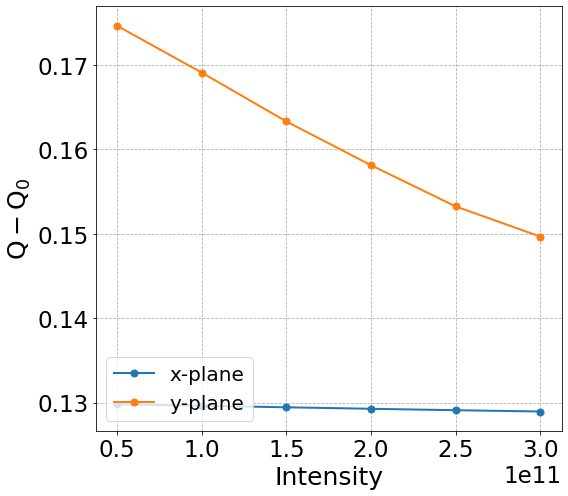

In [17]:
#plt.plot(intensity_list, np.array(Qx_list)-0.13, '-o', c='C0', label='x-plane')
#plt.plot(intensity_list, np.array(Qy_list)-0.22, '-o', c='C1', label='y-plane')


plt.plot(intensity_list, np.array(Qx_list), '-o', c='C0', label='x-plane')
plt.plot(intensity_list, np.array(Qy_list), '-o', c='C1', label='y-plane')


plt.ylabel(r'$\mathrm{Q-Q_0}$')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.tight_layout()

# axis limits
#plt.ylim(0.12, 0.18)

savefig = False
if savefig:
    plt.savefig(f'TuneShift_vs_Intensity_ayy{app_y}_QpxQpy{Qp_x}_ayy{app_y}_QpyQpx{Qp_x}_wakesQ20_2018_complete.png', bbox_inches='tight')

### 10) Compare with theoretical estimation

- https://github.com/natriant/exploring_SPS/blob/master/tuneShift_from_transverese_impedance/DQ_coherent_Chao.ipynb

In [17]:
# Load pickle files
DQy_Chao = pickle.load(open(f'./theoretical_DQ/Qy_coherent_vs_Intensity_Chao_QpyQpx0.0_steps_26GeV_Q20compelte2018_dipolQuads.pkl', 'rb'))
#DQx_Chao = pickle.load(open(f'Qx_coherent_vs_Intensity_Chao_QpyQpx0.0_{wakeContribution}.pkl', 'rb'))

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
DQy_Chao

{'intensity 0.0': -0.0,
 'intensity 12500000000.0': -0.0017697064727107525,
 'intensity 25000000000.0': -0.003539412945421505,
 'intensity 37500000000.0': -0.005309119418132257,
 'intensity 50000000000.0': -0.00707882589084301}

In [19]:
DQy_Chao_list = []
#DQx_Chao_list = []
for intensity in intensity_list:
    DQy_Chao_list.append(DQy_Chao[f'intensity {intensity}'])
    #DQx_Chao_list.append(DQx_Chao[f'intensity {intensity}'])

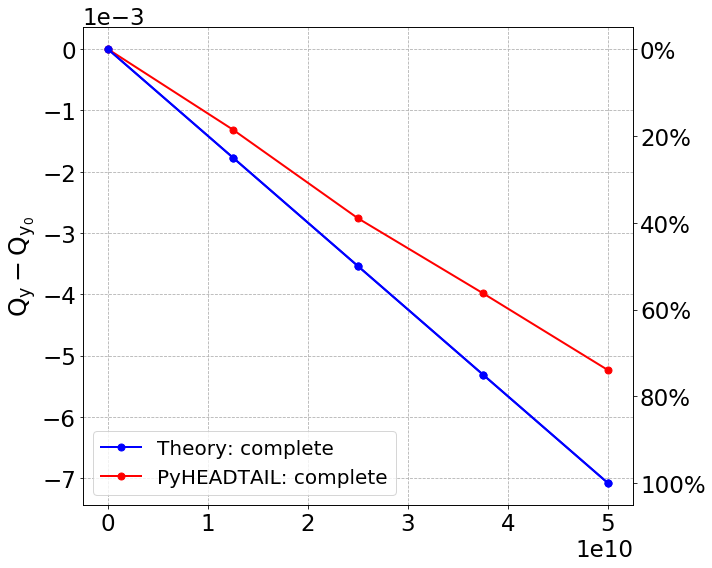

In [21]:
import matplotlib.ticker as mtick

perc = np.linspace(0, 100,len(DQy_Chao_list))


fig, ax1 = plt.subplots(figsize=(10,8))

ax1.plot(intensity_list, DQy_Chao_list, '-o', c='b', label='Theory: complete')
ax1.plot(intensity_list, np.array(Qy_list)-0.25, '-o', c='r', label='PyHEADTAIL: complete')
 
ax1.set_ylabel(r'$\mathrm{Q_y-Q_{y_0}}$')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2 = ax1.twinx() 
ax2.plot(intensity_list, perc, '-o', c='b', label='Theory: complete impedance model')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
ax2.invert_yaxis()

plt.xlabel('Intensity')
ax1.grid(linestyle='dashed')
ax1.legend(loc=3)

plt.tight_layout()

# axis limits
#plt.ylim(-7e-4, 3e-4)#3e-5

savefig = True
if savefig:
    plt.savefig(f'DQy_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_simulationComplete_vsChaoComplete.png', bbox_inches='tight')

### End of main script

In [ ]:
plt.plot(intensity_list, DQy_Chao_list, '-o', c='b', label='Theory: complete impedance model')
plt.plot(intensity_list, np.array(Qy_list)-0.25, '-o', c='r', label='PyHEADTAIL: walls+kickers')
    
plt.ylabel(r'$\mathrm{Q_y-Q_{y_0}}$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.tight_layout()

# axis limits
#plt.ylim(-7e-4, 3e-4)#3e-5

savefig = False
if savefig:
    plt.savefig(f'DQy_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}_{wakeContribution}.png', bbox_inches='tight')

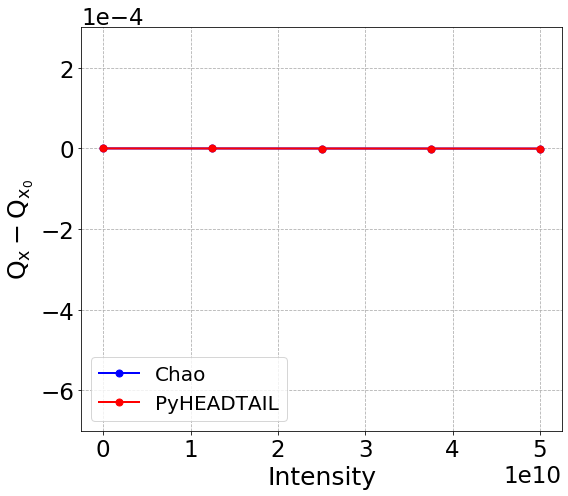

In [26]:
plt.plot(intensity_list, DQx_Chao_list, '-o', c='b', label='theory')
plt.plot(intensity_list, np.array(Qx_list)-0.13, '-o', c='r', label='PyHEADTAIL')
    

plt.ylabel(r'$\mathrm{Q_x-Q_{x_0}}$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.tight_layout()

# axis limits
plt.ylim(-7e-4, 3e-4)#3e-5
#plt.ylim(-7e-6, 1e-7)


savefig = False
if savefig:
    plt.savefig(f'DQx_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}_{wakeContribution}.png', bbox_inches='tight')